In [52]:
import os
import sys
from tqdm import trange
from tqdm import tqdm
from skimage.util import montage
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist.dataset import PathMNIST, ChestMNIST, DermaMNIST, OCTMNIST, PneumoniaMNIST, RetinaMNIST, BreastMNIST, OrganMNISTAxial, OrganMNISTCoronal, OrganMNISTSagittal
from medmnist.evaluator import getAUC, getACC
from medmnist.info import INFO

In [53]:
print("Version:", medmnist.__version__)

Version: 0.2.2


In [54]:
data_flag = 'organmnist_axial'
download = False
input_root = 'tmp_data/'
BATCH_SIZE = 32


flag_to_class = {
    "pathmnist": PathMNIST,
    "chestmnist": ChestMNIST,
    "dermamnist": DermaMNIST,
    "octmnist": OCTMNIST,
    "pneumoniamnist": PneumoniaMNIST,
    "retinamnist": RetinaMNIST,
    "breastmnist": BreastMNIST,
    "organmnist_axial": OrganMNISTAxial,
    "organmnist_coronal": OrganMNISTCoronal,
    "organmnist_sagittal": OrganMNISTSagittal,
}

DataClass = flag_to_class[data_flag]

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])


In [55]:
# preprocessing
data_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(root=input_root, split='train', transform=data_transform, download=download)
valid_dataset = DataClass(root=input_root, split='val', transform=data_transform, download=download)
nonorm_dataset = DataClass(root=input_root, split='train', transform=transforms.ToTensor(), download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = data.DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [56]:
print(train_dataset)
print("===================")
print(valid_dataset)
print("===================")
print(nonorm_dataset)

Dataset OrganMNISTAxial
    Number of datapoints: 34581
    Root location: tmp_data/
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34581, 'val': 6491, 'test': 17778}
    Description: OrganMNIST_Axial: A dataset based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into grey scale with a abdominal window; we then crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1 x 28 x 28 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source traini

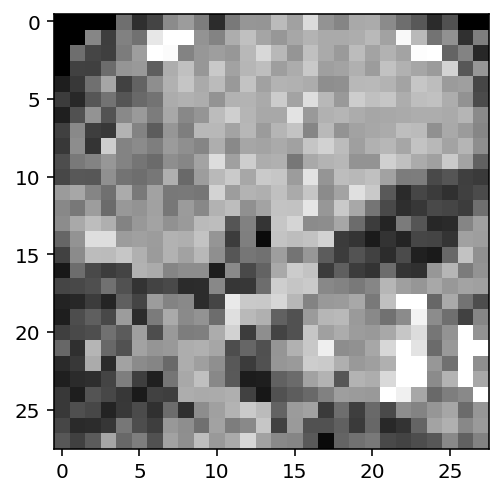

In [57]:
# visualization
img, target = nonorm_dataset[0]
if n_channels == 1:
    img = img.reshape(28, 28)
    plt.imshow(img, cmap='gray')
else:
    img = img.permute(1, 2, 0)
    plt.imshow(img)

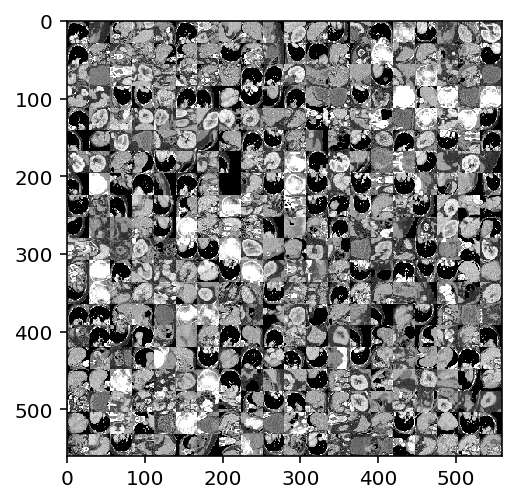

In [58]:
# montage

def process(n_channels, length=20):
    scale = length * length

    image = np.zeros((scale, 28, 28, 3)) if n_channels == 3 else np.zeros((scale, 28, 28))
    index = [i for i in range(scale)]
    np.random.shuffle(index)
    
    for idx in range(scale):
        img, _ = nonorm_dataset[idx]
        if n_channels == 3:
            img = img.permute(1, 2, 0).numpy()
        else:
            img = img.reshape(28, 28).numpy()
        image[index[idx]] = img

    if n_channels == 1:
        image = image.reshape(scale, 28, 28)
        arr_out = montage(image)
        plt.imshow(arr_out, cmap='gray')
    else:
        image = image.reshape(scale, 28, 28, 3)
        arr_out = montage(image, multichannel=3)
        plt.imshow(arr_out)
    
process(n_channels=n_channels, length=20)

In [59]:
from datetime import datetime 
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [60]:
%config InlineBackend.figure_format = 'retina'
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = n_classes


In [84]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true.view(X.size(0)).long()).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true.view(X.size(0)).long()) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true.view(X.size(0)).long()) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

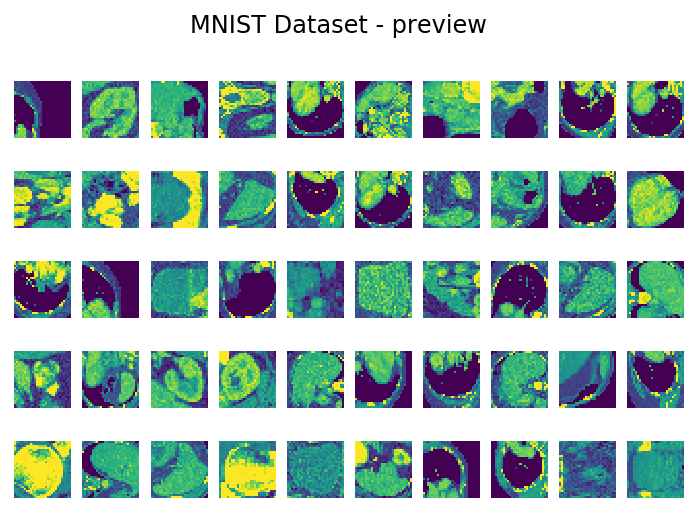

In [62]:
ROW_IMG = 10
N_ROWS = 5
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.img[index])
fig.suptitle('MNIST Dataset - preview');

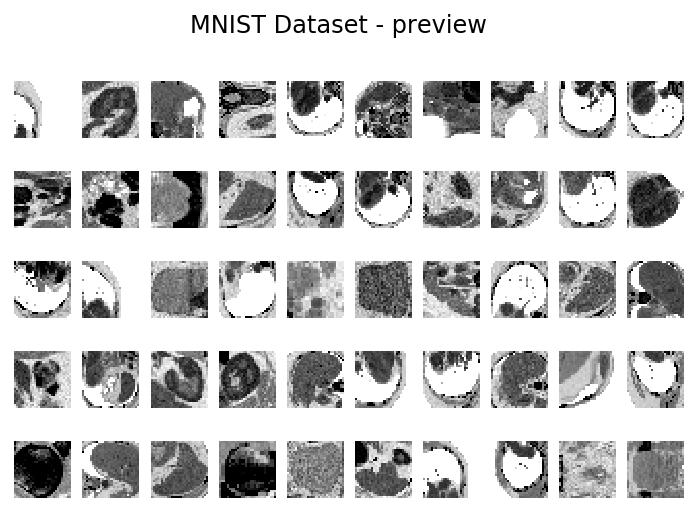

In [63]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.img[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

In [64]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [65]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

01:28:25 --- Epoch: 0	Train loss: 0.0203	Valid loss: 0.4104	Train accuracy: 99.47	Valid accuracy: 93.85
01:28:45 --- Epoch: 1	Train loss: 0.0192	Valid loss: 0.4717	Train accuracy: 99.20	Valid accuracy: 92.61
01:29:06 --- Epoch: 2	Train loss: 0.0242	Valid loss: 0.3952	Train accuracy: 99.74	Valid accuracy: 93.73
01:29:28 --- Epoch: 3	Train loss: 0.0140	Valid loss: 0.4225	Train accuracy: 99.77	Valid accuracy: 93.48
01:29:48 --- Epoch: 4	Train loss: 0.0245	Valid loss: 0.4525	Train accuracy: 98.88	Valid accuracy: 92.67
01:30:09 --- Epoch: 5	Train loss: 0.0185	Valid loss: 0.4582	Train accuracy: 99.68	Valid accuracy: 92.47
01:30:30 --- Epoch: 6	Train loss: 0.0185	Valid loss: 0.5301	Train accuracy: 98.61	Valid accuracy: 91.16
01:30:50 --- Epoch: 7	Train loss: 0.0145	Valid loss: 0.4301	Train accuracy: 99.60	Valid accuracy: 93.62
01:31:10 --- Epoch: 8	Train loss: 0.0171	Valid loss: 0.4175	Train accuracy: 98.73	Valid accuracy: 92.79
01:31:32 --- Epoch: 9	Train loss: 0.0190	Valid loss: 0.4875	Trai

C:\subwin\software\anaconda\envs\python3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


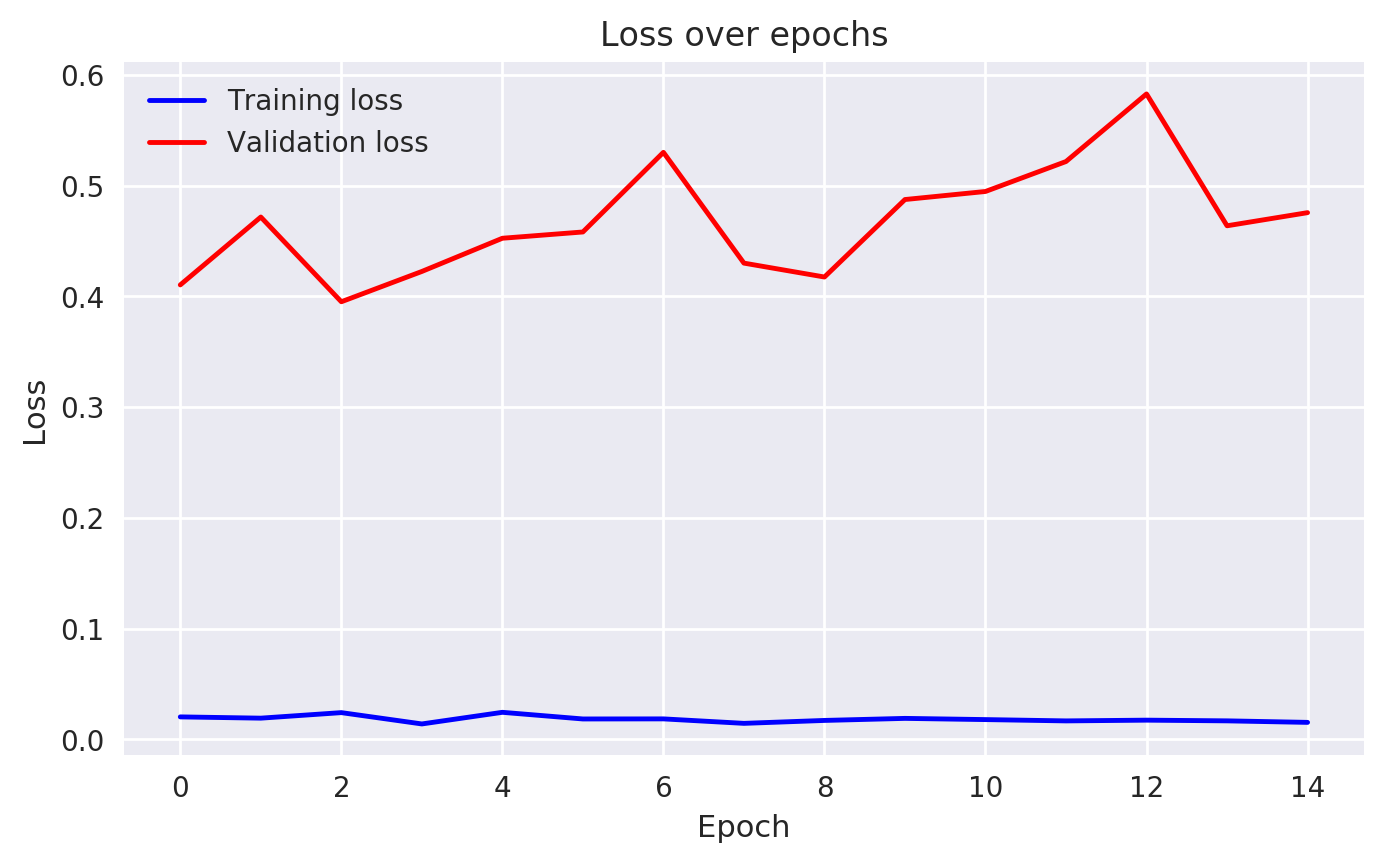

In [85]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)


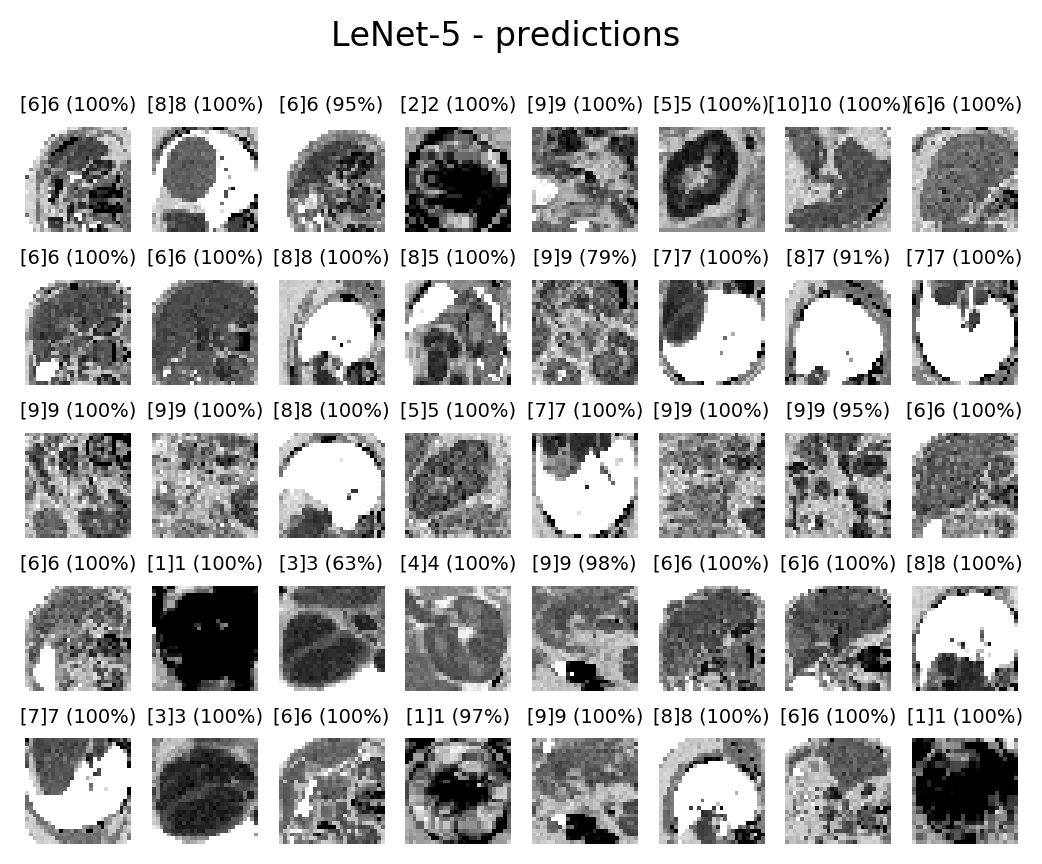

In [88]:
ROW_IMG = 8
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.img[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{valid_dataset.label[index]}{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');